In [1]:
import numpy as np
import torch
import os
import net_low2 as net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 64
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 2
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = True
RUN_NAME = '4x2x2'

# Network and optimizer

In [3]:
model = net.AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:2


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (enc1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|█████████████████████████████████████████| 610/610 [02:03<00:00,  4.92it/s]


Epoch: 1 	Training Loss: 0.055225 	Val Loss: 0.045354	     in time 2.126804m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 2 	Training Loss: 0.041489 	Val Loss: 0.038318	     in time 2.141603m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.90it/s]


Epoch: 3 	Training Loss: 0.035698 	Val Loss: 0.033100	     in time 2.144320m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 4 	Training Loss: 0.029218 	Val Loss: 0.023877	     in time 2.144363m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 5 	Training Loss: 0.018585 	Val Loss: 0.014145	     in time 2.144953m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 6 	Training Loss: 0.011038 	Val Loss: 0.008439	     in time 2.146603m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 7 	Training Loss: 0.007090 	Val Loss: 0.006138	     in time 2.146133m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 8 	Training Loss: 0.005739 	Val Loss: 0.005383	     in time 2.151017m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 9 	Training Loss: 0.005176 	Val Loss: 0.004918	     in time 2.148512m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.90it/s]


Epoch: 10 	Training Loss: 0.004892 	Val Loss: 0.004705	     in time 2.146437m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.90it/s]


Epoch: 11 	Training Loss: 0.004686 	Val Loss: 0.004609	     in time 2.144880m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 12 	Training Loss: 0.004561 	Val Loss: 0.004531	     in time 2.147536m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 13 	Training Loss: 0.004496 	Val Loss: 0.004331	     in time 2.145628m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 14 	Training Loss: 0.004376 	Val Loss: 0.004309	     in time 2.147957m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 15 	Training Loss: 0.004347 	Val Loss: 0.004243	     in time 2.147622m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 16 	Training Loss: 0.004264 	Val Loss: 0.004162	     in time 2.146688m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 17 	Training Loss: 0.004219 	Val Loss: 0.004103	     in time 2.147591m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 18 	Training Loss: 0.004160 	Val Loss: 0.004070	     in time 2.149921m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 19 	Training Loss: 0.004121 	Val Loss: 0.004034	     in time 2.148490m


100%|█████████████████████████████████████████| 610/610 [02:04<00:00,  4.89it/s]


Epoch: 20 	Training Loss: 0.004071 	Val Loss: 0.003975	     in time 2.152367m
CPU times: user 34min 45s, sys: 11min, total: 45min 46s
Wall time: 42min 55s


# Results - middle layer has 64x4x2x2

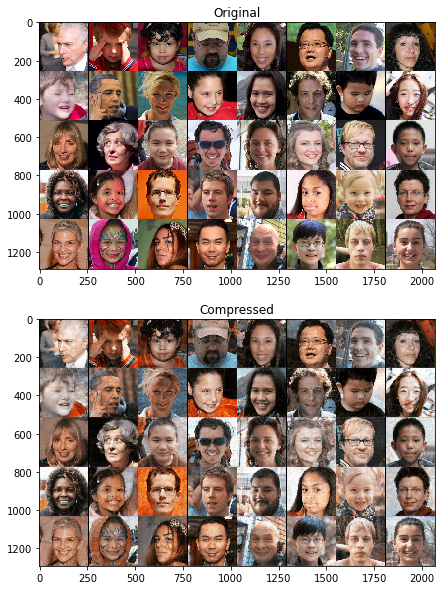

In [14]:
utils.show(val_pred_grid,val_true_grid)

In [15]:
path = Path("results") / RUN_NAME

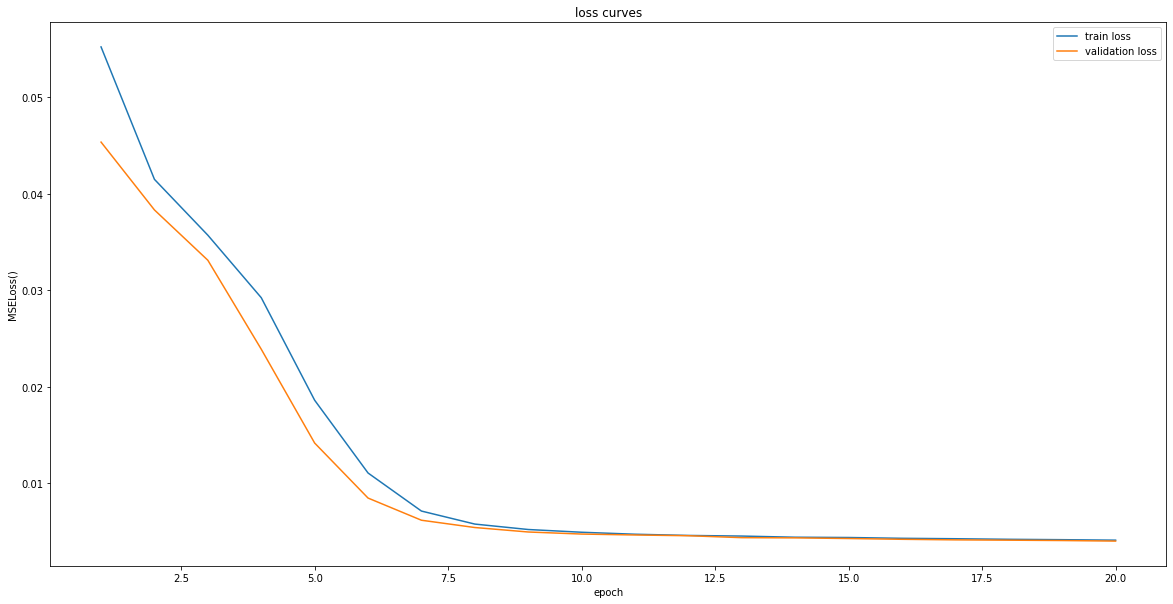

In [16]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [17]:
utils.write_losses(path, train_losses, val_losses)

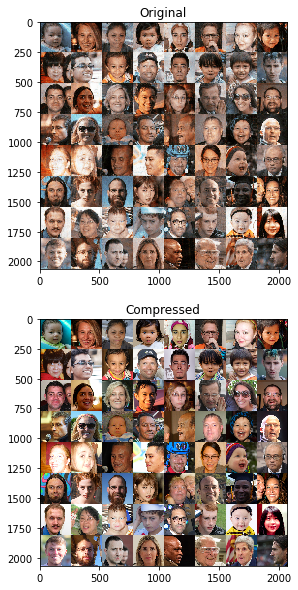

In [18]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)